# Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
       z_m, z_logv = inputs
       batch = tf.shape(z_m)[0]
       dim = tf.shape(z_m)[1]
       eps = tf.keras.backend.random_normal(shape=(batch, dim))
       return z_m + tf.exp(z_logv / 2) * eps



## Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

Complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

For the encoder structure I reuse the same model I built in the previous homework, when we have to define the Deep-Autoencoders.In the end, as we can see from the numbers generated below, it works quite well also for this task so I decided to keep it.

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_inputs)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(encoded)
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(encoded)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 512)          401920      input_21[0][0]                   
__________________________________________________________________________________________________
dense_78 (Dense)                (None, 256)          131328      dense_77[0][0]                   
__________________________________________________________________________________________________
dense_79 (Dense)                (None, 128)          32896       dense_78[0][0]                   
____________________________________________________________________________________________

## Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

For the decoder I use the same structure of the previous encoder, but in the reverse order.
In this case we have the following reduction and expansion in the Dense layers:
784->-512->256->128->2 in the encoder and 128->256->512->784 in the decoder


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

decoded = tf.keras.layers.Dense(128, activation='relu')(latent_inputs)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoder_outputs = tf.keras.layers.Dense(784,activation='sigmoid')(decoded) 

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_81 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_82 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_83 (Dense)             (None, 784)               402192    
Total params: 567,184
Trainable params: 567,184
Non-trainable params: 0
_________________________________________________________________


## Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)


            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),axis =0))
            kl_loss = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))


            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

## Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

Changing the scale factor will, of course, affect the type of numbers the network generates. If I choose a very small scale factor the network will generate very similar numbers, as in the first image below where, with a scale factor of 0.2, the network only generates three and eight (which are also very similar to each other). This is due to the fact that the network is not taking advantage of all the latent space and only samples the values ​​that are near the center. In the opposite case, if I choose a too large scale factor, the network will generate  not very good representation of the numbers, this is because the values ​​it samples from the latent space are very far from the representation it learns. In the next cell is plotted the representation of the latent space, with its cluster of digits, that the network learns. If we observe it we can try, given the scale factor, to understand 'a priori' which numbers the network will generate. If we want to generate different types of numbers we have to choose a scale factor that is neither too big nor too small. In the images below we can see that, if we choose 2 as the scale factor, the network will generate almost all the numbers, in other words it will exploit the latent space very well.



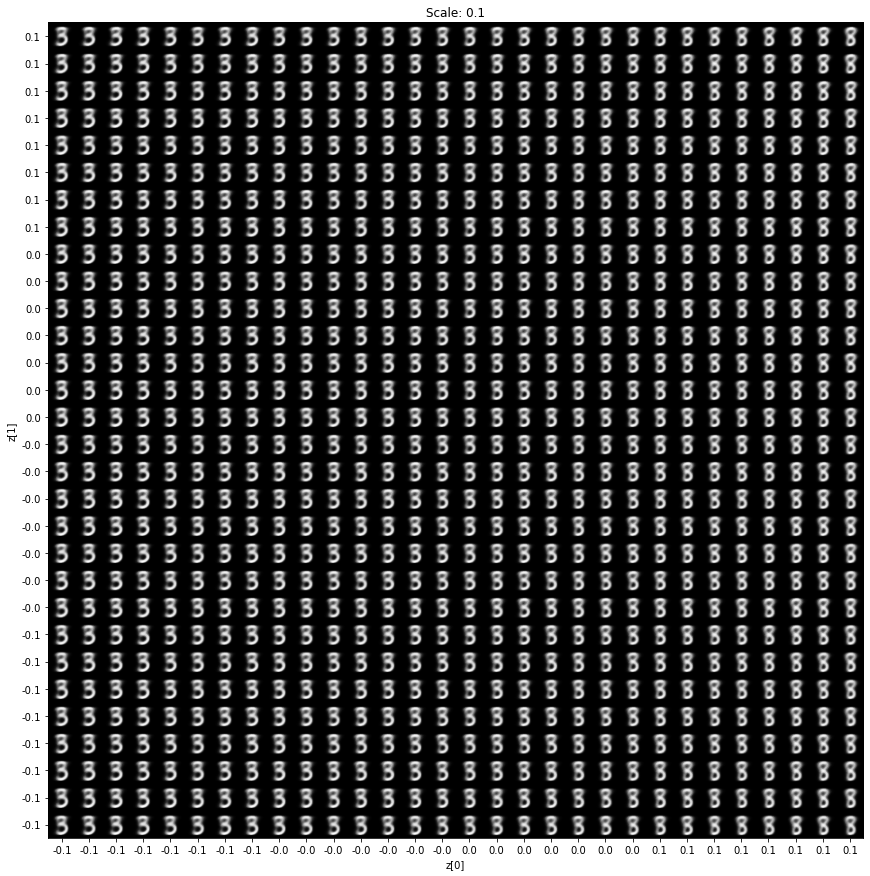

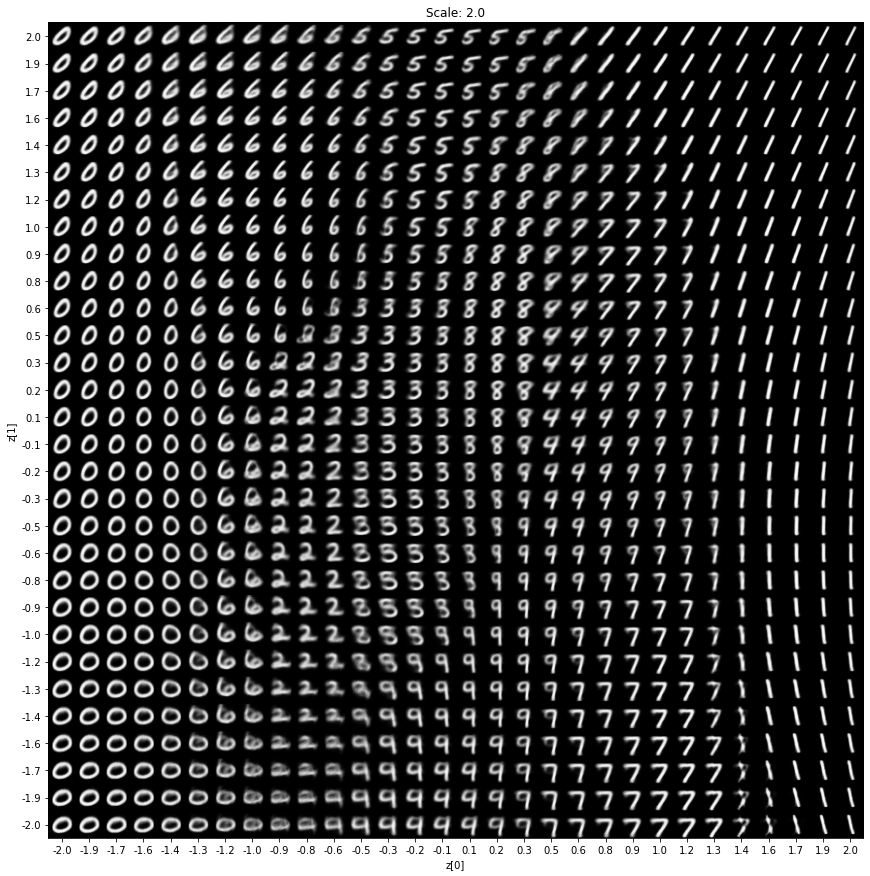

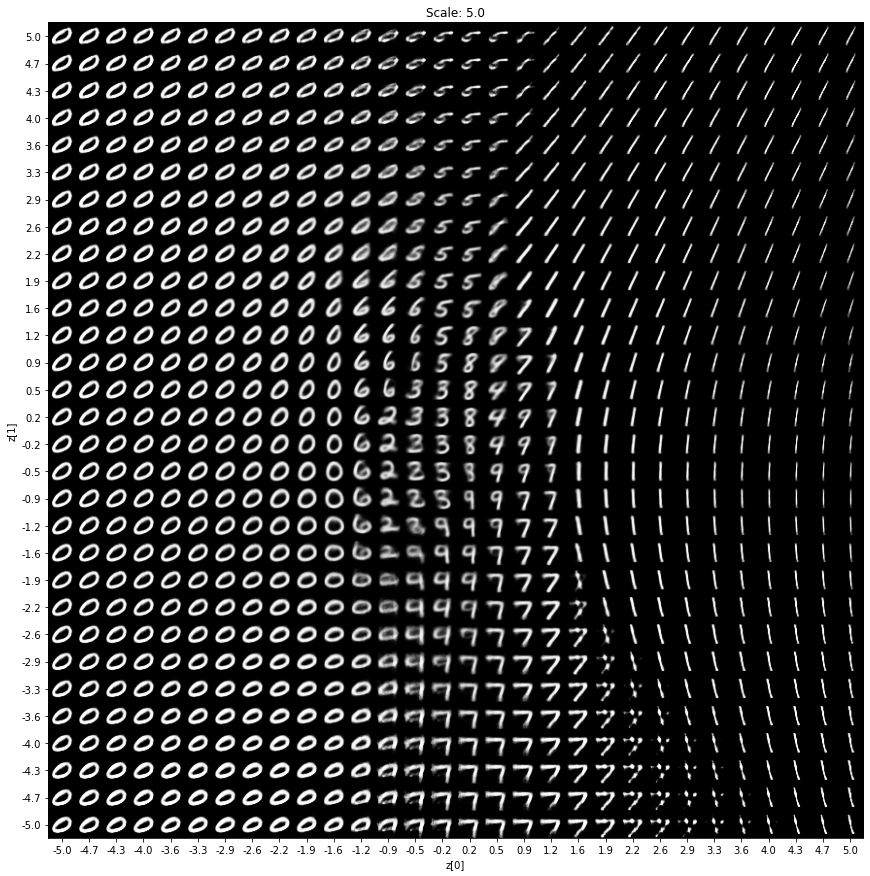

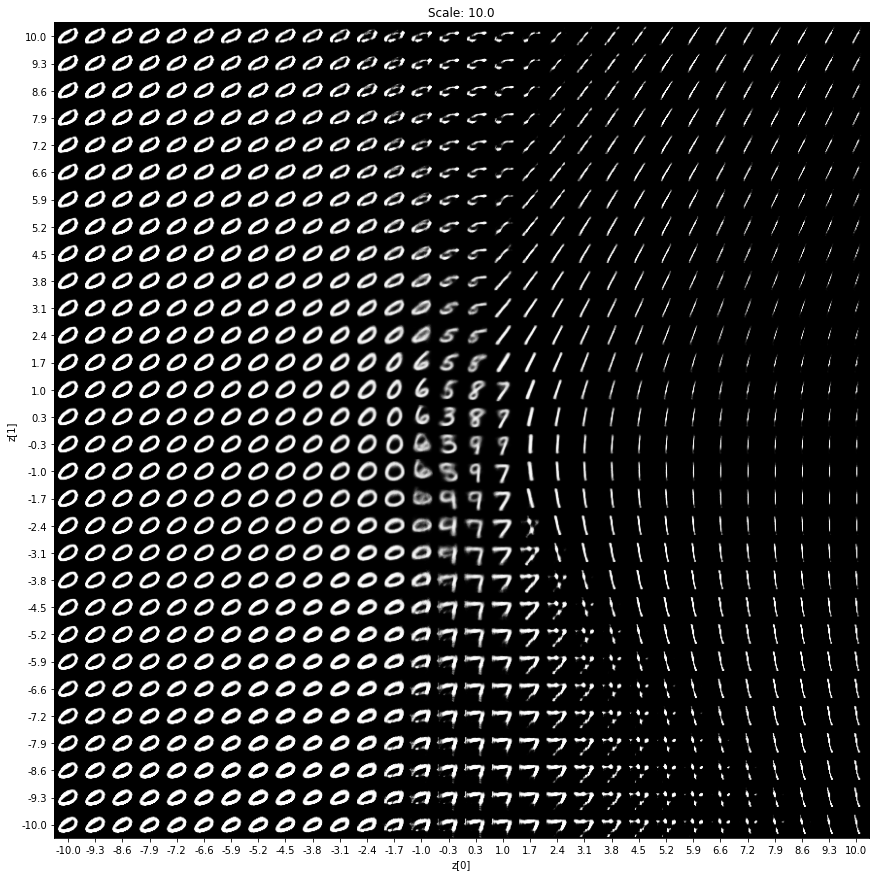

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Scale: {}".format(scale))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(encoder, decoder, 0.1, 30) 
plot_latent(encoder, decoder, 2.0, 30) 
plot_latent(encoder, decoder, 5.0, 30) 
plot_latent(encoder, decoder, 10.0, 30) 



Let's finally check how the various digits have been rapresented in the latent space by the VAE.

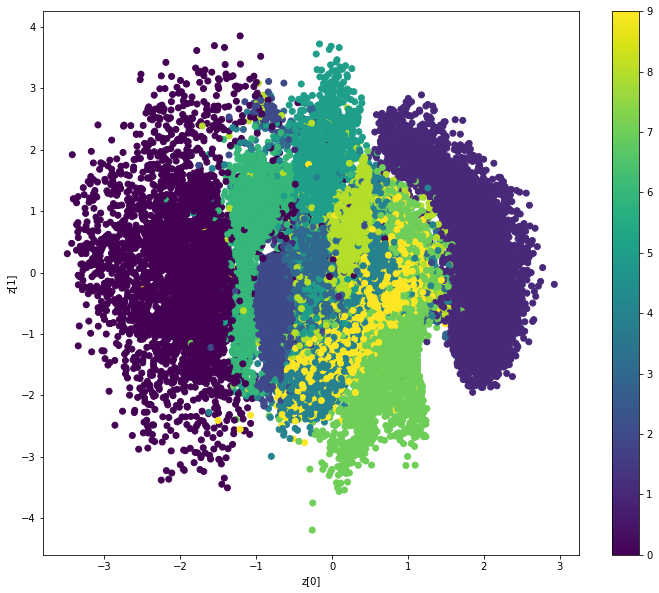

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

In the previous image is represented the clusters of different digit in latent space. The latent space is where the algorithm will sample to generate new digits. Different colour represent different digits. If the sampled values will be inside, or near, a particular cluster the algorithm will generate a similar number, related to that cluster. Obviously this works well if the Variational AutoEncoder is able to learn a good approximation of the a priori probability distribution of the input. 

Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

Here I tried to build different networks, changing the size and the number of layers, to see if one of them is able to understand a better representation of the a priori probability of the input. Furthermore, for each model, I ploted the latent representation learned by the networks, so we can see how the models group the digits in the latent space.

In this first model I tried to use a 'strong' compression in the Encoder part. The generated numbers are very similar to the previous one. The only thing is that the numbers near the center are more blurry and so it is not so easy to understand what the number is. It can also be seen in latent space that the clusters, near the center, are not well separated.

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(encoder_inputs)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(16, activation='relu')(encoded)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(encoded)
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(encoded)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")


latent_inputs = keras.Input(shape=(latent_dim,))

decoded = tf.keras.layers.Dense(16, activation='relu')(latent_inputs)
decoded = tf.keras.layers.Dense(32, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoder_outputs = tf.keras.layers.Dense(784,activation='sigmoid')(decoded) 

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

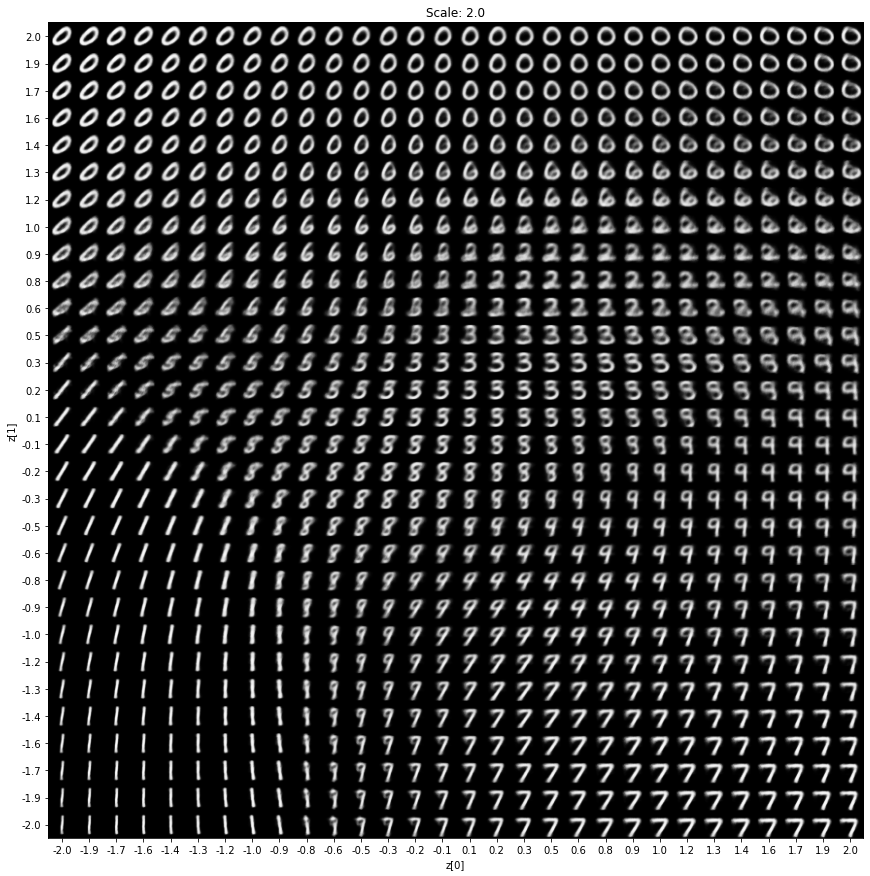

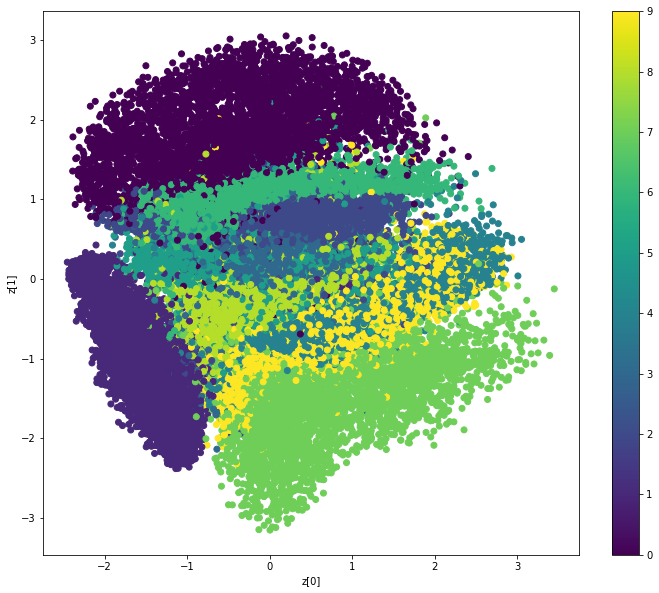

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Instead, in this second model, I tried not to compress too much
the input. In this case the generated numbers are quite good but the model learns, respect the others, a different representation in the latent space. In fact the cluster of digits in latent space has a vertical shape, which is a bit odd but works well in practice.

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(600, activation='relu')(encoder_inputs)
encoded = tf.keras.layers.Dense(500, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(400, activation='relu')(encoded)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(encoded)
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(encoded)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")


latent_inputs = keras.Input(shape=(latent_dim,))

decoded = tf.keras.layers.Dense(400, activation='relu')(latent_inputs)
decoded = tf.keras.layers.Dense(500, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(600, activation='relu')(decoded)
decoder_outputs = tf.keras.layers.Dense(784,activation='sigmoid')(decoded) 

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

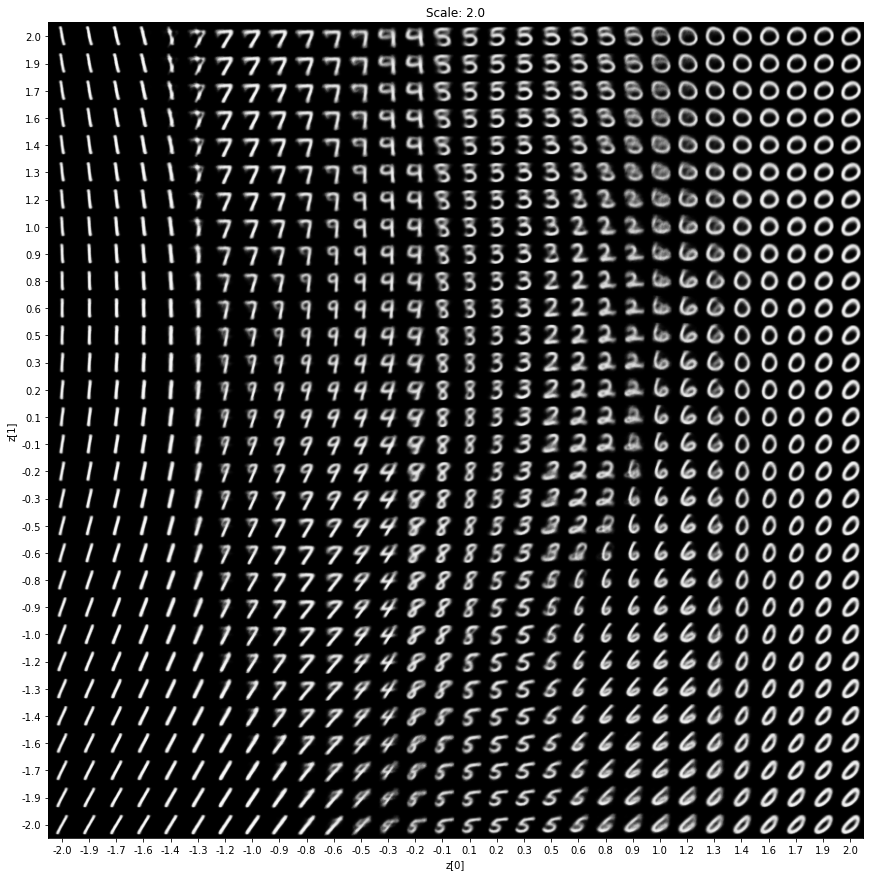

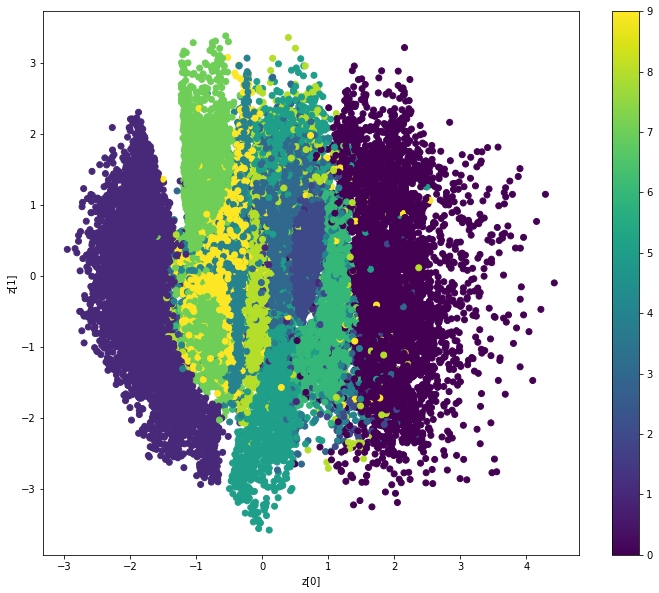

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Finally I tried to increase the number of layer for the Encoding-Decoding part. This is a more complicated network than the others and therefore the representations in latent space are also more sophisticated. Despite the complexity of the model, the numbers generated are very similar to those generated by the others.

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_inputs)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)


z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(encoded)
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(encoded)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")


latent_inputs = keras.Input(shape=(latent_dim,))
decoded = tf.keras.layers.Dense(32, activation='relu')(latent_inputs)
decoded = tf.keras.layers.Dense(64, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoder_outputs = tf.keras.layers.Dense(784,activation='sigmoid')(decoded) 

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

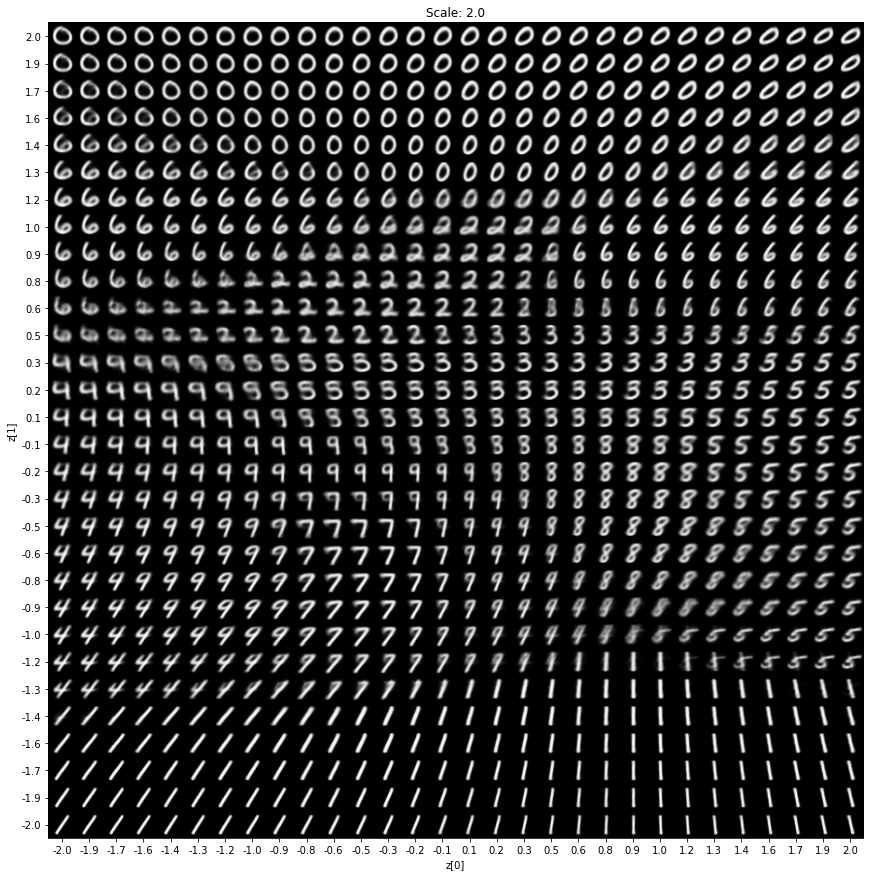

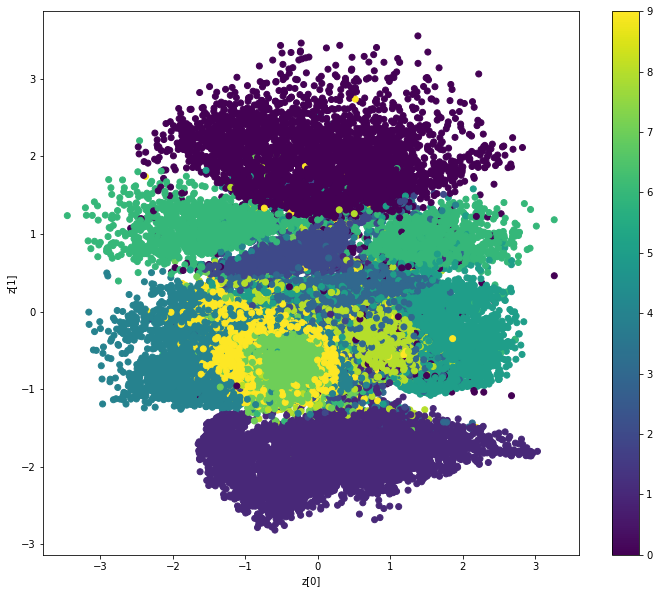

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Finally I think that the best model, despite the strange representation in latent space, is the one in which there is not too much compression in the Encoder part. Basically the second one.
